### 今回使う手法の一覧
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。


最近傍法
ロジスティック回帰
SVM
決定木
ランダムフォレスト

### 練習のための準備
練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、**問題を単純化するためアヤメの種類を2つだけ使うことにします**。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

### 【課題1】練習のために特徴量とカテゴリを選択
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。


virgicolorとvirginica<br>
sepal_lengthとpetal_length

《実際の問題では？》


実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [232]:
import pandas as pd
from sklearn.datasets import load_iris

# 下準備
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=["target"])
df = pd.concat([X, y], axis=1)
df

# 抜き出す
df = pd.concat([df["sepal length (cm)"], df["petal length (cm)"],df["target"]], axis=1)
df.drop(range(0,50), axis=0, inplace=True)
df

,sepal length (cm),petal length (cm),target
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1
...,...,...,...
145,6.7,5.2,2
146,6.3,5.0,2
147,6.5,5.2,2
148,6.2,5.4,2


# 【問題2】データの分析
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。


ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。


《実際の問題では？》


このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。


今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。



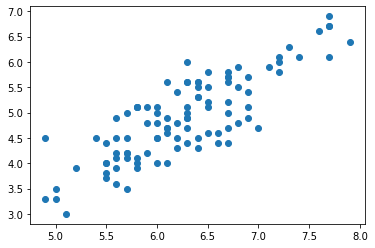

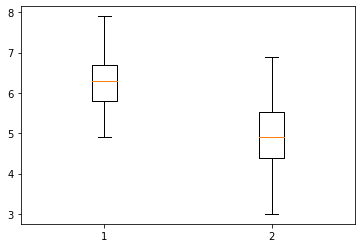

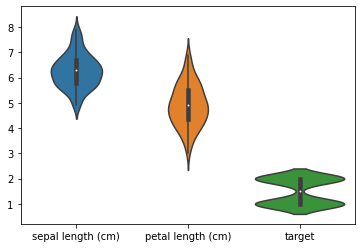

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

# 散布図
plt.scatter(df["sepal length (cm)"], df["petal length (cm)"])
plt.show()

# 箱ひげ図
plt.boxplot([df["sepal length (cm)"], df["petal length (cm)"]])
plt.show()

# バイオリン図
sns.violinplot(data=df)
plt.show()

# 【問題3】前処理・訓練データと検証データの分割
前処理の一貫として、訓練データと検証データの分割を行います。今回は訓練データ75%、検証データ25%として分割してください。


scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。


sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation


《注意点》


データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。


《分割する理由》


分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練データ、検証に使うデータが検証データで、一般的に7対3から8対2程度の割合にします。

In [234]:
from sklearn.model_selection import train_test_split

X = pd.concat([df["sepal length (cm)"], df["petal length (cm)"]],axis=1).to_numpy()
y = df["target"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


# 【問題4】前処理・標準化
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。


標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。


sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation


《注意点》


標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。また、今回は分類問題なので、ラベルについては標準化させる必要はありません。


《実際の問題での前処理は？》


アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。



In [235]:
from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler()
scaler_train = scaler.fit_transform(X_train)
scaler_test = scaler.transform(X_test)

array([[ 7.91707539e-01, -1.20936285e-01],
       [ 3.81787899e-02,  8.46553995e-01],
       [ 9.42413289e-01,  2.14825997e-15],
       [ 1.99735354e+00,  2.05591684e+00],
       [ 1.39453054e+00,  1.33029913e+00],
       [ 7.91707539e-01,  1.20936285e+00],
       [-1.01676146e+00, -4.83745140e-01],
       [ 3.81787899e-02,  2.14825997e-15],
       [ 3.39590289e-01,  1.08842656e+00],
       [ 6.41001789e-01,  3.62808855e-01],
       [ 3.81787899e-02,  8.46553995e-01],
       [-7.15349959e-01,  2.41872570e-01],
       [ 1.88884540e-01,  8.46553995e-01],
       [-2.63232710e-01, -2.41872570e-01],
       [-2.07170171e+00, -1.93498056e+00],
       [-1.16746721e+00, -1.33029913e+00],
       [ 3.81787899e-02,  2.14825997e-15],
       [ 1.88884540e-01, -7.25617710e-01],
       [-4.13938459e-01,  2.41872570e-01],
       [ 4.90296039e-01, -3.62808855e-01],
       [-1.92099596e+00, -1.93498056e+00],
       [ 7.91707539e-01,  7.25617710e-01],
       [-1.16746721e+00, -1.08842656e+00],
       [-1.

# 【問題5】学習と推定
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練データです。


sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation


学習が終わった後、検証データをpredictメソッドに入力し、推定を行ってください。


パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。



In [257]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter("ignore")

model = KNeighborsClassifier(n_neighbors=5)
model.fit(scaler_train, y_train)

# 推定
pred = model.predict(scaler_test)
pred

array([1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1])

# 【問題6】評価
検証データの特徴量を入力して得られた推定値と、検証データの正解値の近さを計算し、学習したモデルを評価します。


2値分類を評価するための指標値には Accuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 があります。それぞれの意味を理解するには、 混同行列（confusion matrix） を見ることになります。


scikit-learnを使い4種類の指標を計算する
混同行列をscikit-learnを使い表示する
4種類の指標値の意味について簡単に調査して文章でまとめる

sklearn.metrics.accuracy_score — scikit-learn 0.21.3 documentation


sklearn.metrics.precision_score — scikit-learn 0.21.3 documentation


sklearn.metrics.recall_score — scikit-learn 0.21.3 documentation


sklearn.metrics.f1_score — scikit-learn 0.21.3 documentation


sklearn.metrics.confusion_matrix — scikit-learn 0.21.3 documentation

In [256]:
from sklearn.metrics import recall_score,accuracy_score,precision_score, f1_score, confusion_matrix

#混合行列
print(confusion_matrix(pred, y_test)) 
# TN11,FP2,FN0,TP12


# 各指標
print("正解率は{}".format(accuracy_score(pred, y_test))) 
print("適合率は{}".format(precision_score(pred, y_test)))
print("再現率は{}".format(recall_score(pred, y_test)))
print("F値は{}".format(f1_score(pred, y_test)))

'''
意味
confusion_matrix：
TN,FP,FN,TPの4つの指標があり、Nはnegative、Pはpositiveを示す。
猫に例えるとNは実際の値が猫ではない、Pは実際の値が猫である、という状況下で分類されている。

accuracy_score：
数式で表すと(TP+TN)/(TP+FP+FN+TN)
意味は単純に正解した値が全体でどれくらいあったかを見ている。
そのため、FPとFNは考慮されていないためこの値のみを信じるのは危険。

precision_score：
数式で表すと(TP)/(TP+FP)
猫だけど間違えて猫ではない、と予測する確率を見る事が可能。
FNは考慮しないので、FNを許容できる場合に利用する。

recall_score：
数式で表すと(TP)/(TP+FN)
猫ではないものを猫、と予測する確率を見る事が可能。
FPは考慮しないので、FPを許容できる場合に利用する。

f1_score：
数式で表すと(2*recall*precision)/(recall+precision)
precisionとrecallの中間のイメージ。
FP,FN両方考慮する時に利用する。

'''

[[10  0]
 [ 3 12]]
正解率は0.88
適合率は0.7692307692307693
再現率は1.0
F値は0.8695652173913044


'\n意味\nconfusion_matrix：\nTN,FP,FN,TPの4つの指標があり、Nはnegative、Pはpositiveを示す。\n猫に例えるとNは実際の値が猫ではない、Pは実際の値が猫である、という状況下で分類されている。\n\naccuracy_score：\n数式で表すと(TP+TN)/(TP+FP+FN+TN)\n意味は単純に正解した値が全体でどれくらいあったかを見ている。\nそのため、FPとFNは考慮されていないためこの値のみを信じるのは危険。\n\nprecision_score：\n数式で表すと(TP)/(TP+FP)\n猫だけど間違えて猫ではない、と予測する確率を見る事が可能。\nFNは考慮しないので、FNを許容できる場合に利用する。\n\nrecall_score：\n数式で表すと(TP)/(TP+FN)\n猫ではないものを猫、と予測する確率を見る事が可能。\nFPは考慮しないので、FPを許容できる場合に利用する。\n\nf1_score：\n数式で表すと(2*recall*precision)/(recall+precision)\nprecisionとrecallの中間のイメージ。\nFP,FN両方考慮する時に利用する。\n\n'

# 【問題7】可視化
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練データまたは検証データを与えます。

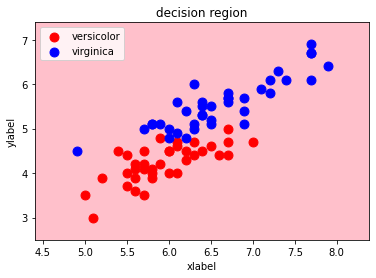

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
decision_region(X_train, y_train, model)

# 問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。


最近傍法
ロジスティック回帰
SVM
決定木
ランダムフォレスト

公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。


sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation
sklearn.linear_model.LogisticRegression — scikit-learn 0.21.3 documentation
sklearn.svm.SVC — scikit-learn 0.21.3 documentation
sklearn.tree.DecisionTreeClassifier — scikit-learn 0.21.3 documentation
sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation

《実際の問題では？》


ハイパーパラメータの調整は パラメータチューニング と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。



正解率は0.88
適合率は0.7692307692307693
再現率は1.0
F値は0.8695652173913044
[[10  0]
 [ 3 12]]


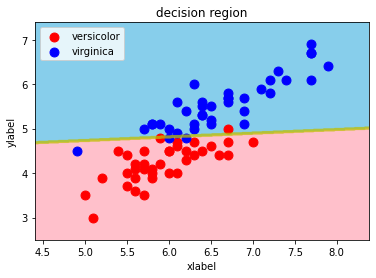

'\n考察\nロジスティック回帰を使うと、k近傍法より精度が落ちている。\nパラメータのチューニング次第で変化があると思う。\nこの場合CをGridserchで調整する感じ。\nまた、シグモイド関数に重回帰分析の式を入れるイメージなので、高次元に対応しないはず。\nあまり利用するイメージがない。。。\nただ、このチューニングにfor文やrandom_stateも変更すれば処理がとても重くなるので\n組み込みPCなど処理をあげたマシンを使うのが一般的？？\n'

In [261]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression

# DLと学習
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

# 推定
pred = model_log.predict(X_test)

# 評価
print("正解率は{}".format(accuracy_score(pred, y_test))) 
print("適合率は{}".format(precision_score(pred, y_test)))
print("再現率は{}".format(recall_score(pred, y_test)))
print("F値は{}".format(f1_score(pred, y_test)))
print(confusion_matrix(pred, y_test)) 

decision_region(X_train, y_train, model_log)

'''
考察
ロジスティック回帰を使うと、k近傍法より精度が落ちている。
パラメータのチューニング次第で変化があると思う。
この場合CをGridserchで調整する感じ。
また、シグモイド関数に重回帰分析の式を入れるイメージなので、高次元に対応しないはず。
あまり利用するイメージがない。。。
ただ、このチューニングにfor文やrandom_stateも変更すれば処理がとても重くなるので
組み込みPCなど処理をあげたマシンを使うのが一般的？？
'''

正解率は0.88
適合率は0.7692307692307693
再現率は1.0
F値は0.8695652173913044
[[10  0]
 [ 3 12]]


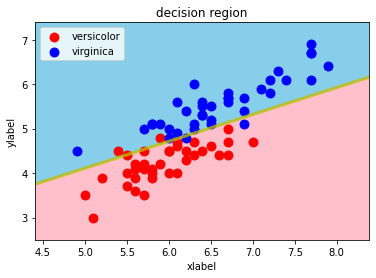

'\n考察\nロジスティック回帰とSVCの精度が一緒。\nパラメータのチューニング次第で変化があると思う。\nこの場合C,tol,penalty,損失をGridserchで調整する感じ。\nlinearを使う場面も少なそうで、どちらかというと非線形のSVCを使うイメージ。\n基本２値分類で説明されるので、利用頻度は低そう？\n\n'

In [223]:
# SVM
from sklearn.svm import LinearSVC

# DLと学習
model_svc = LinearSVC()
model_svc.fit(X_train, y_train)

# 推定
pred = model_svm.predict(X_test)

# 評価
print("正解率は{}".format(accuracy_score(pred, y_test))) 
print("適合率は{}".format(precision_score(pred, y_test)))
print("再現率は{}".format(recall_score(pred, y_test)))
print("F値は{}".format(f1_score(pred, y_test)))
print(confusion_matrix(pred, y_test)) 

decision_region(X_train, y_train, model_svc)
'''
考察
ロジスティック回帰とSVCの精度が一緒。
パラメータのチューニング次第で変化があると思う。
この場合C,tol,penalty,損失をGridserchで調整する感じ。
linearを使う場面も少なそうで、どちらかというと非線形のSVCを使うイメージ。
基本２値分類で説明されるので、利用頻度は低そう？

'''

正解率は0.88
適合率は0.7692307692307693
再現率は1.0
F値は0.8695652173913044
[[10  0]
 [ 3 12]]


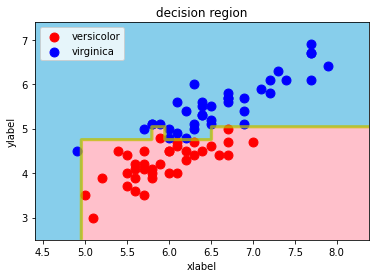

'\n考察\n精度はどっこいどっこい。\nパラメータのチューニング次第でもそこまで差が出るか不明。\nmaxdepthの調整と、giniかentorpyかで若干変化があるか、程度の予感なので\n個人的には特徴量を可視化する以外の方法では利用しないと思う。\n'

In [263]:
 # 決定木
from sklearn.tree import DecisionTreeClassifier

#モデルと学習
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

# 推定
pred = model_tree.predict(X_test)

# 評価
print("正解率は{}".format(accuracy_score(pred, y_test))) 
print("適合率は{}".format(precision_score(pred, y_test)))
print("再現率は{}".format(recall_score(pred, y_test)))
print("F値は{}".format(f1_score(pred, y_test)))
print(confusion_matrix(pred, y_test)) 


decision_region(X_train, y_train, model_tree)

'''
考察
精度はどっこいどっこい。
パラメータのチューニング次第でもそこまで差が出るか不明。
maxdepthの調整と、giniかentorpyかで若干変化があるか、程度の予感なので
個人的には特徴量を可視化する以外の方法では利用しないと思う。
'''

正解率は0.84
適合率は0.6923076923076923
再現率は1.0
F値は0.8181818181818181
[[ 9  0]
 [ 4 12]]


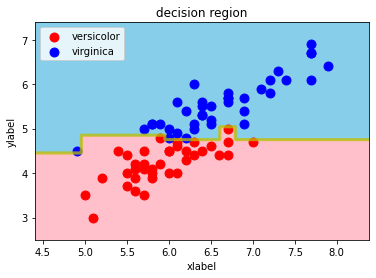

'\n考察\n決定木よりも評価が低いことが以外。\nおそらく学習木が多いので精度が落ちていると思える。\nチューニングは決定木と違いはほとんどないが、メソッドを10個ほど使ったことがないので\nそこら辺で差が出そう。\n'

In [225]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

model_random = RandomForestClassifier().fit(X_train, y_train)

# 推定
pred = model_random.predict(X_test)

# 評価
print("正解率は{}".format(accuracy_score(pred, y_test))) 
print("適合率は{}".format(precision_score(pred, y_test)))
print("再現率は{}".format(recall_score(pred, y_test)))
print("F値は{}".format(f1_score(pred, y_test)))
print(confusion_matrix(pred, y_test)) 


decision_region(X_train, y_train, model_random)

'''
考察
決定木よりも評価が低いことが以外。
おそらく学習木が多いので精度が落ちていると思える。
チューニングは決定木と違いはほとんどないが、メソッドを10個ほど使ったことがないので
そこら辺で差が出そう。
'''

'''
まとめ
図を見ると、k近傍法の線が最も柔軟に対応しているので１番値が高い。
ロジスティック回帰はシグモイドのように分断されているかと思っていたので予想外だった。
また、ランダムフォレストが決定木よりも精度が低いのでチューニングが欲しいところ。
'''

# 【問題9】（アドバンス課題）標準化の有無の比較
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

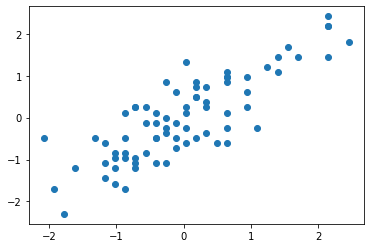

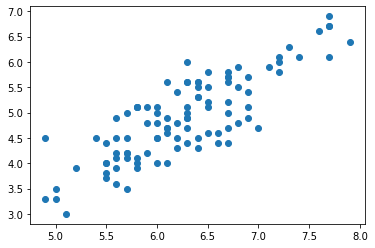

In [254]:
# 正規化の意味
# そもそも数値の意味が違うから。（身長と年齢等）
# 正規化をすると意味が統一されるため、扱いやすい。

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler_train = scaler.fit_transform(X_train)
scaler_test = scaler.transform(X_test)

# 図
plt.scatter(scaler_train[:,0], scaler_train[:, 1])
plt.show()
plt.scatter(df["sepal length (cm)"], df["petal length (cm)"])
plt.show()

# 微妙に単位と点の位置が異なる。

# 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。


《多値になることでの変更点》


指標値Precision（適合率）、Recall（再現率）、F値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。


決定領域を可視化する前述の関数は適切に書き換える必要があります。以下が出力例です。



In [264]:
# 下準備
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=["target"])
df = pd.concat([X, y], axis=1)

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# 標準化
scaler = StandardScaler()
scaler_train = scaler.fit_transform(X_train)
scaler_test = scaler.transform(X_test)

# アルゴリズム
model_log = LogisticRegression().fit(scaler_train, y_train)
model_random = RandomForestClassifier().fit(scaler_train, y_train)
model_svc = LinearSVC().fit(scaler_train, y_train)
model_tree = DecisionTreeClassifier().fit(scaler_train, y_train)

# 推測
pred_log =model_log.predict(scaler_test) 
pred_ramdom = model_random.predict(scaler_test)
pred_svc = model_svc.predict(scaler_test)
pred_tree =model_tree.predict(scaler_test)


In [272]:
# 評価（ロジスティック）
print("正解率は{}".format(accuracy_score(pred_log, y_test))) 
print("適合率は{}".format(precision_score(pred_log, y_test, average="micro")))
print("再現率は{}".format(recall_score(pred_log, y_test, average="weighted")))
print("F値は{}".format(f1_score(pred_log, y_test, average="macro")))
print(confusion_matrix(pred_log, y_test)) 

正解率は0.9736842105263158
適合率は0.9736842105263158
再現率は0.9736842105263158
F値は0.9717034521788342
[[13  0  0]
 [ 0 15  0]
 [ 0  1  9]]


In [274]:
# 評価（ランダムフォレスト）
print("正解率は{}".format(accuracy_score(pred_ramdom, y_test))) 
print("適合率は{}".format(precision_score(pred_ramdom, y_test, average="micro")))
print("再現率は{}".format(recall_score(pred_ramdom, y_test, average="weighted")))
print("F値は{}".format(f1_score(pred_ramdom, y_test, average="macro")))
print(confusion_matrix(pred_log, y_test)) 

正解率は0.9736842105263158
適合率は0.9736842105263158
再現率は0.9736842105263158
F値は0.9717034521788342
[[13  0  0]
 [ 0 15  0]
 [ 0  1  9]]


In [275]:
# 評価（SVC）
print("正解率は{}".format(accuracy_score(pred_svc, y_test))) 
print("適合率は{}".format(precision_score(pred_svc, y_test, average="micro")))
print("再現率は{}".format(recall_score(pred_svc, y_test, average="weighted")))
print("F値は{}".format(f1_score(pred_svc, y_test, average="macro")))
print(confusion_matrix(pred_svc, y_test)) 

正解率は0.9473684210526315
適合率は0.9473684210526315
再現率は0.9473684210526315
F値は0.9421296296296297
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]


In [276]:
# 評価（決定木）
print("正解率は{}".format(accuracy_score(pred_tree, y_test))) 
print("適合率は{}".format(precision_score(pred_tree, y_test, average="micro")))
print("再現率は{}".format(recall_score(pred_tree, y_test, average="weighted")))
print("F値は{}".format(f1_score(pred_tree, y_test, average="macro")))
print(confusion_matrix(pred_tree, y_test)) 

'''
結論
0.9736842105263158が最も高く
SVC以外のランダムフォレスト、決定木、ロジスティック回帰の数値が高い。
また、正解率、適合率、再現率が高い
'''


正解率は0.9736842105263158
適合率は0.9736842105263158
再現率は0.9736842105263158
F値は0.9717034521788342
[[13  0  0]
 [ 0 15  0]
 [ 0  1  9]]
